In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import requests

from bs4 import BeautifulSoup

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
# parser нельзя использовать как имя модуля - оно уже занято в дефолтном Питоне

%run gks_parser.py

# к сожалению, из-за косяков Chromedriver и Windows приходится запускать модуль
# импорт модуля и запуск класса не работает, увы

# from gks_parser import CPIparser
# Parser = CPIparser()
# скачаем данные с сайта Росстата
# Parser.get_gks_data()
# переформатируем их в человеческий вид
# Parser.preprocess()

Data for cpi already exists
Do you want to override existing file? Yes/No: yes
Data for cpi is overwritten
Data for foods already exists
Do you want to override existing file? Yes/No: yes
Data for foods is overwritten
Data for nonfoods already exists
Do you want to override existing file? Yes/No: yes
Data for nonfoods is overwritten
Data for services already exists
Do you want to override existing file? Yes/No: yes
Data for services is overwritten
Data for weights already exists
Do you want to override existing file? Yes/No: yes
Data for weights is overwritten
Data for CPI.xlsx is reformated


Там какая-то лажа с адресом ссылки - буквы с цифрами рандомные видимо связаны с моей конкретной сессией, после закрытия страницы вернуться на неё по этой же ссылке нельзя. Надо сделать новый парсер с Selenium.
Вот эта ссылка, например, вроде нормальная:
https://rosstat.gov.ru/price

In [16]:
data = pd.read_csv('data/clean_cpi.csv', index_col=0, parse_dates=True)

In [17]:
data.head()

,cpi
month,
1991-01-31,106.2
1991-02-28,104.8
1991-03-31,106.3
1991-04-30,163.5
1991-05-31,103.0


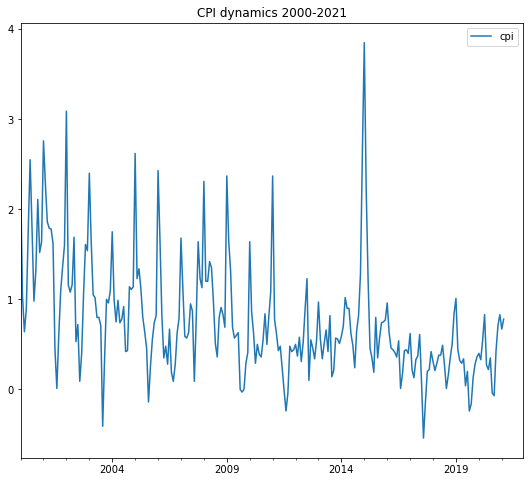

In [28]:
(data['2000':]-100).plot(label='CPI', title='CPI dynamics 2000-2021', figsize=(9, 8));

In [29]:
def seasonal_plot(ts, n_periods, plot_size, 
                  title, xlabel, ylabel):
    '''Seasonal chart for n_periods in year'''
    colors = plt.cm.viridis_r(np.linspace(0,1,ts.index.year.unique().shape[0]))
    
    plt.figure(figsize=plot_size)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    for i, year in enumerate(ts.index.year.unique().values.tolist()):
        plt.plot(list(range(1, n_periods+1)), ts[str(year)].values, label=str(year), color=colors[i])
    plt.legend(bbox_to_anchor=(1.05, 1)); 

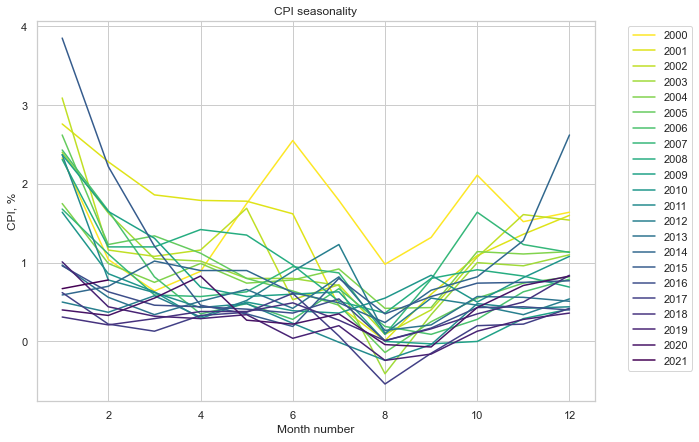

In [50]:
seasonal_plot(ts=data['2000':]-100, plot_size=(10, 7), n_periods=12,
              title='CPI seasonality', ylabel='CPI, %', xlabel='Month number')

In [59]:
def range_plot(data, frequency, current_year,
              title, figsize, xlabel, ylabel,
              drop_year=None):
    '''
    frequency: "month", "quarter" 
    current_year - year to plot separately with line plot
    drop_year - year(s) not do display in variable range
    '''
    
    sns.set(style='whitegrid')   
        
    n_periods = getattr(data.index, frequency).unique().shape[0]
    low = data.groupby(getattr(data.index, frequency)).agg(np.min).values.reshape(n_periods)
    high = data.groupby(getattr(data.index, frequency)).agg(np.max).values.reshape(n_periods)
    
    if drop_year:
        if isinstance(drop_year, list):
            first, last = drop_year[0], drop_year[1]
        elif isinstance(drop_year, tuple):
            first, last = drop_year
        else:
            first = drop_year
            last = first
        
        data2 = data.drop(
            index=data[str(first):str(last)].index.values.squeeze())
    
        low = data2.groupby(getattr(data2.index, frequency)).agg(np.min).values.reshape(n_periods)
        high = data2.groupby(getattr(data2.index, frequency)).agg(np.max).values.reshape(n_periods)
        
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.fill_between(x=getattr(data.index, frequency).unique().values, 
                     y1=high, y2=low, color='lightgray', alpha=0.8)
    
    ax.plot(getattr(data[str(current_year)].index, frequency),
             data[str(current_year)].values,
             color='blue', label=str(current_year))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    

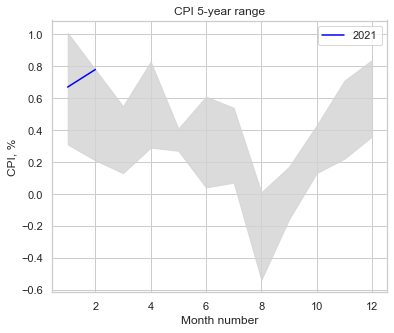

In [60]:
range_plot((data['2016':]-100), 'month', 2021,
          'CPI 5-year range', (6, 5),'Month number', 'CPI, %')

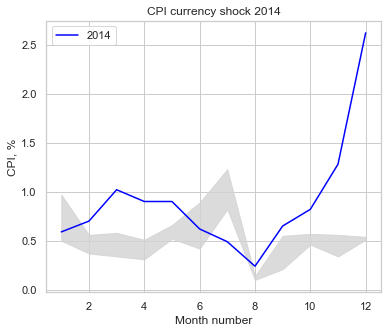

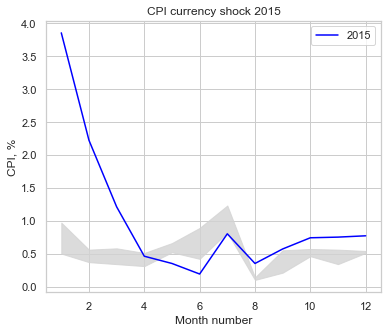

In [58]:
range_plot(data['2012':'2015']-100, 'month', 2014,
          'CPI currency shock 2014', (6, 5),'Month number', 'CPI, %',
          drop_year = [2014, 2015])

range_plot(data['2012':'2015']-100, 'month', 2015,
          'CPI currency shock 2015', (6, 5),'Month number', 'CPI, %',
          drop_year = [2014, 2015])

C:\Users\Vladimir\anaconda3\envs\portfolio\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


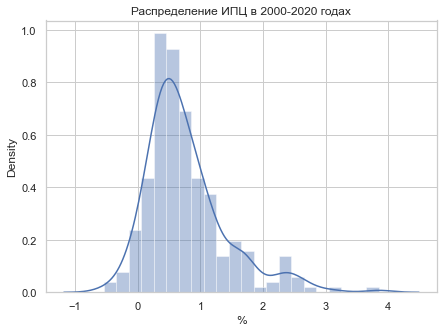

In [41]:
sns.set(style='whitegrid');
plt.figure(figsize=(7, 5))
plt.title('Распределение ИПЦ в 2000-2020 годах');
sns.distplot(data['2000':]-100);
plt.xlabel('%');

Посмотрим на выбросы.

In [155]:
(data['2000':]-100)[(data['2000':].cpi-100)>=2.5]

,cpi
2000-06-30,2.55
2001-01-31,2.76
2002-01-31,3.09
2005-01-31,2.62
2014-12-31,2.62
2015-01-31,3.85


In [156]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [182]:
result = sm.tsa.stattools.adfuller(data.dropna().cpi.values.squeeze(),
                                  regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.256625
p-value: 0.000007
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


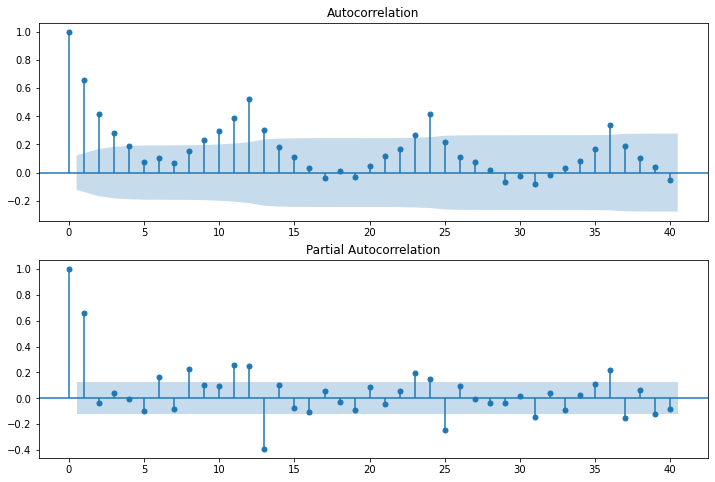

In [178]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf((data['2000':]-100).dropna(), 
                                    lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf((data['2000':]-100).dropna(), 
                                    lags=40, ax=ax2)

* Судя по коррелограмме, можно рассмотреть модели SARIMAX(1,0,0)(1,0,1), SARIMAX(1,0,0)(2,0,2), SARIMAX(1,0,1)(1,0,1). Можно рассматривать данные после 2002 года, нужно добавить дамми на 2014 и 2015 годы (шок). 
* Ряд стационарный, гипотеза ADF-теста с дрифтом.
* Преобразование Бокса-Кокса не нужно, поскольку примерно в 2012 году дисперсия резко меняется и с той поры остаётся стабильной (смена экономической модели?).

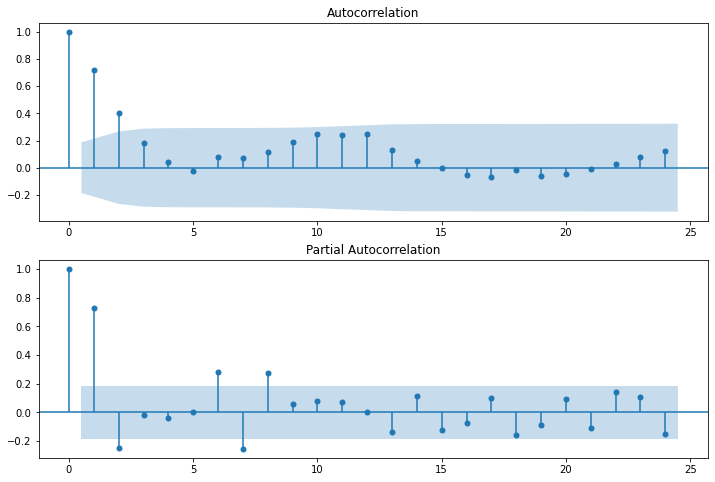

In [186]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf((data['2012':]-100).dropna(), 
                                    lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf((data['2012':]-100).dropna(), 
                                    lags=24, ax=ax2)

In [187]:
train = data['2000':'2018']-100

In [262]:
sarimax1 = ARIMA(train.cpi, 
                 order=(1,0,0),
                 seasonal_order=(1,0,1, 12), 
                 trend='c')
res1 = sarimax1.fit()
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                cpi   No. Observations:                  228
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -96.950
Date:                            Fri, 02 Apr 2021   AIC                            203.900
Time:                                    01:12:45   BIC                            221.047
Sample:                                01-31-2000   HQIC                           210.818
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8452      0.289      2.923      0.003       0.278       1.412
ar.L1          0.7127      0.040   

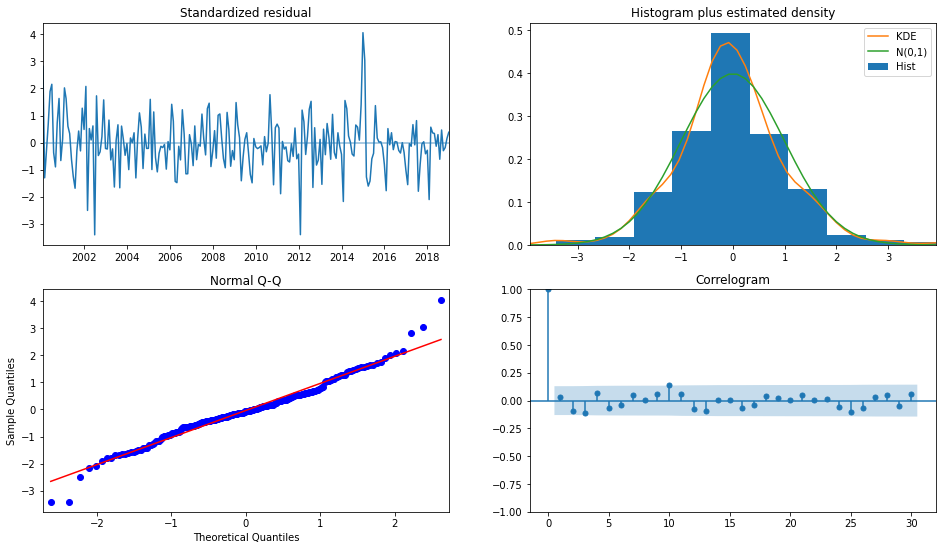

In [236]:
fig = plt.figure(figsize=(16,9))
fig = res1.plot_diagnostics(fig=fig, lags=30)

Дамми-переменная для шока.

In [250]:
data['shock']=0
data=data.astype({'shock':'float64'})
data['2014-11'].shock=0.25
data['2014-12'].shock=0.5
data['2015-01'].shock=1.0
data['2015-02'].shock=0.5
data['2015-03'].shock=0.25
data['2014-11':'2015-03']

C:\Users\Vladimir\anaconda3\envs\portfolio\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,cpi,shock
2014-11-30,101.28,0.25
2014-12-31,102.62,0.50
2015-01-31,103.85,1.00
2015-02-28,102.22,0.50
2015-03-31,101.21,0.25


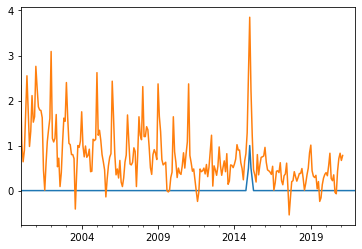

In [255]:
data['2000':].shock.plot();
(data['2000':].cpi-100).plot();

In [311]:
train = data['2000':'2018']
train.cpi-=100

In [312]:
train.head()

,cpi,shock
2000-01-31,2.33,0.0
2000-02-29,1.04,0.0
2000-03-31,0.64,0.0
2000-04-30,0.89,0.0
2000-05-31,1.75,0.0


In [313]:
mod_dummy = ARIMA(endog=train.cpi, 
                  exog=train.shock,
                  order=(1,0,0),
                  seasonal_order=(1,0,1, 12), 
                  trend='c') #'n' if no constant mean assumed
res2 = mod_dummy.fit()
print(res2.summary())

C:\Users\Vladimir\anaconda3\envs\portfolio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                cpi   No. Observations:                  228
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -73.965
Date:                            Fri, 02 Apr 2021   AIC                            159.930
Time:                                    01:35:31   BIC                            180.506
Sample:                                01-31-2000   HQIC                           168.232
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8312      0.229      3.622      0.000       0.381       1.281
shock          2.7743      0.331   

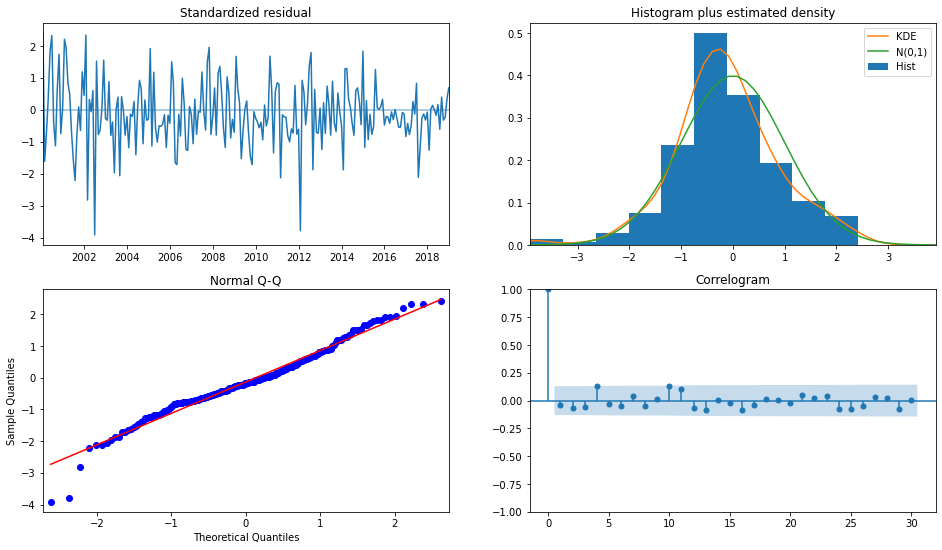

In [314]:
fig = plt.figure(figsize=(16,9))
fig = res2.plot_diagnostics(fig=fig, lags=30)

Отдельный вопрос - стоит ли добавлять в модель константу. На качество она особо не влияет. Возможно, стоит всё-таки подумать над преобразованием Бокса-Кокса в связи со сменой экономической модели - об этом наглядно говорят остатки.

**В 2019-2021 годах в какой-то момент при преобразованиях добавилось лишнее 100 - быть аккуратным, вычистить.**

Видно, что модель с дамми-переменной явно лучше.